In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
       print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")

In [ ]:
cases=pd.read_csv("/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv")
deaths=pd.read_csv("/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv")
recovered=pd.read_csv("/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv")
it_cases= pd.read_csv("/kaggle/input/covid19-in-italy/covid19_italy_region.csv")
       
#Concat/transpose/rename
df=pd.concat( [cases[cases["Country/Region"]=="Italy"],deaths[deaths["Country/Region"]=="Italy"],recovered[recovered["Country/Region"]=="Italy"]], ignore_index=True)
df=df.T
df=df.drop(["Province/State","Country/Region","Lat","Long"])
df=df.rename(columns={0:"cases", 1:"deaths",2:"recovered" })
df.index=pd.to_datetime(df.index, format='%m/%d/%y')
df.tail(10)



In this notebook I will try to model the active COVID19 cases in Italy during the quarantine. I'm no epidemiologist, so I will just test if a simple mathematical model on the total number of active cases is enough to get some valuable information and assess the change in growth. 

In [ ]:
# adding recent data (source https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy)

#df=df[:-1]
#new_data = pd.DataFrame({ "dates":['2020-03-23', '2020-03-24','2020-03-25'],
#                          "cases":[63927, 69176, 74386], 
#                          "deaths":[6077, 6820, 7503],
#                         "recovered":[7432,8326,9362]}) 

#new_data.set_index("dates", inplace=True, drop=True)
#new_data.index=pd.to_datetime(new_data.index, format='%Y/%m/%d')
#df=pd.concat([df,new_data])
#df.tail(20)

First, add the following metrics
               
* 1. N Current Cases 
* 2. DR Death Rate
* 3. GR Growth rate

In [ ]:
#Correct errors
df.loc[df.index == "2020/03/12", ['cases','deaths',"recovered"]] = [15133,1016,1228]

# ADD metrics
#current cases
df["N"]=df["cases"]-df["deaths"]-df["recovered"]
#death rate
df=df[df.cases>0]
df["dr"]=df["deaths"]/df["cases"]
#growth rate
df["gr"]=df["N"]/df["N"].shift(+1)


df.tail(30)

# Model description:

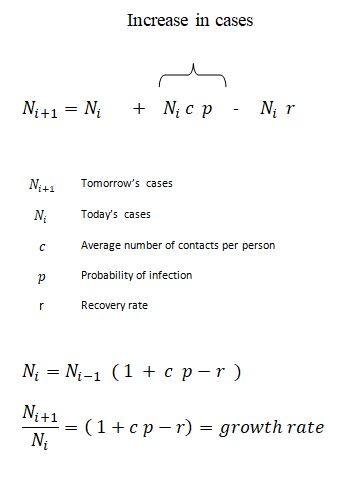

In [ ]:
#visualize new metrics

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(25, 4), dpi=80)

plt.subplot(1,3,1)
plt.plot(df["N"])
plt.xticks(rotation='vertical')
plt.title ("Current cases: N")

plt.subplot(1,3,2)
plt.plot(df["dr"])
plt.xticks(rotation='vertical')
plt.title ("death rate")

plt.subplot(1,3,3)
plt.plot(df[df.cases> 250].gr)
plt.xticks(rotation='vertical')
plt.title ("Growth Rate")



Despite the growth rate shows a clear decreasing trend, it has been hard to determine the correct slope due to the presence of outliers in the early days of the outbreak.  The country went into a full lockdown on March 9th.


In [ ]:
#removing values before the quarantine started and preparing dataset for linear modelling

from datetime  import datetime

limit="2020-03-09"

grdata=pd.DataFrame()
grdata["ds"]=df.index.values
grdata["y"]=df.gr.values
grdata["ds"]=pd.to_datetime(grdata["ds"], format='%m/%d/%y')
grdata=grdata[grdata.ds >= limit]
grdata.head(10)


# Model:

In [ ]:
#Prophet linear modelling (Growth Rate := today/yesterday)

from fbprophet import Prophet

mod = Prophet(weekly_seasonality=False, interval_width=0.80)
mod.fit(grdata)

future = mod.make_future_dataframe(periods=15)
forecast = mod.predict(future)
fig2 = mod.plot(forecast)

Removing outliers and recalculating the line using only the most recent values revealed a slower decrease than initially expected.


# Forecast:

In [ ]:
#calculate future values of cases
forecast["fc"]="0"
forecast.set_index(forecast["ds"], inplace=True)
forecast.index=pd.to_datetime(forecast.index, format="%Y-%m-%d")
today=df.tail(1).index.values[0]

forecast2=forecast.iloc[forecast.index>today]

forecast2["fc"]= forecast[forecast.index>today]["yhat"].cumprod()
forecast2["fco"]= forecast[forecast.index>today]["yhat_lower"].cumprod()
forecast2["fcp"]= forecast[forecast.index>today]["yhat_upper"].cumprod()

forecast2["fc"]= forecast2["fc"]*df.tail(1).N.values[0]
forecast2["fco"]= forecast2["fco"]*df.tail(1).N.values[0]
forecast2["fcp"]= forecast2["fcp"]*df.tail(1).N.values[0]


In [ ]:
#combine historical data and forecast
output=pd.concat([df,forecast2])
#output.tail(45)

In [ ]:
figure(num=None, figsize=(25, 4), dpi=80)
plt.ylim((0,100000))
plt.xticks(rotation='vertical')

plt.plot(output["N"])
plt.plot(output["fc"])
plt.plot(output["fco"])
plt.plot(output["fcp"])


Tiny adjustments in the slope of the linear model  cause disproportional impacts on the number of cases at peak time.

# Which regions are generating most of the new Cases?



In [ ]:
#group by region
reg_cases=it_cases.groupby(['RegionName','Date'])[['CurrentPositiveCases']].sum()

#new cases by region
reg_cases['NewCases']=reg_cases['CurrentPositiveCases']-reg_cases['CurrentPositiveCases'].shift(+1)
reg_cases.loc[reg_cases.NewCases <=0, ["NewCases"]] = 0
reg_cases=reg_cases.reset_index()

#format date
reg_cases['Date']=reg_cases['Date'].str.slice(stop=10)

# total daily cases
new_cases=reg_cases.groupby(['Date'])[['NewCases']].sum()
new_cases=new_cases.rename(columns={"NewCases": "Tot"})

# filter on date (after the quarantine  started)
reg_cases_q=reg_cases[reg_cases.Date>='2020-03-09'][['Date','RegionName','NewCases']]
reg_cases_q=reg_cases_q.join(new_cases, on='Date')
reg_cases_q['New']=reg_cases_q['NewCases']/reg_cases_q['Tot']
reg_cases_q=reg_cases_q.sort_values(["Date","New",],ascending=False)
reg_cases_q.reset_index()

#regional contribution of new cases
reg_cases_q['cumsum']=0

for date in reg_cases_recent['Date'].drop_duplicates():
    reg_cases_recent.loc[reg_cases_recent.Date==date, ['cumsum']]=reg_cases_recent[reg_cases_recent.Date==date]['New'].cumsum()


In [ ]:
#plot regions that generated most of the cases in the last 10 days

figure(num=None, figsize=(30, 15), dpi=80)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

i=1
dates=reg_cases_q['Date'].drop_duplicates().sort_values()

for date in dates:
    
    bardata=reg_cases_q[(reg_cases_q['Date']==date)&(reg_cases_q["cumsum"]<0.8)]
    bardata.sort_values('New', inplace=True, ascending=False)
    
    plt.subplot(5,5,i)
    plt.title(date)
    plt.bar(bardata['RegionName'], bardata['New'])
    plt.xticks(rotation='vertical')
    i=i+1


Keeping an eye on which regions are contributing to the residual growth over time. The bar chart shows the origin of the new cases each day.

In [ ]:
figure(num=None, figsize=(15, 5), dpi=80)

top_regions=reg_cases_q.groupby(['RegionName'])[['New']].mean()
top_regions=top_regions.sort_values('New', ascending=False)
top_regions=top_regions.head(6) 

A=reg_cases_q.join(top_regions.drop("New", axis=1), how="inner", on="RegionName")
A=A.sort_values("Date")

bars= pd.DataFrame({"Date":[],"Regions":[],"percentage":[],"cumsum":[]})

for date in dates:
    bar= pd.DataFrame({"Date":[],"Regions":[],"percentage":[],"cumsum":[]})
    for region in top_regions.index:
        r = pd.DataFrame({'Date':[date],'Regions':[region],'percentage':[A[(A.RegionName==region)&(A.Date==date)].New.values[0]]})
        bar=bar.append(r)

    bar["cumsum"]=bar["percentage"].cumsum()
    other=pd.DataFrame({'Date':[date],'Regions':["Other"],'percentage':[1-bar["cumsum"].max()], "cumsum":[bar["cumsum"].max()]})
    bar=bar.append(other)
    bar["cumsum"]=bar["cumsum"].shift(+1).fillna(0)
    
    
    bars=bars.append(bar)

    
date_lab = dates
width=5
N=np.arange((width+2)*dates.shape[0], step=(width+2))
fig, ax = plt.subplots(figsize=(15,5))


for region in bars.Regions.drop_duplicates():
   ax.bar(N, bars[(bars.Regions==region)]['percentage'], width, bottom=bars[(bars.Regions==region)]['cumsum'], label=region)
    
ax.set_ylabel('percentage of daily cases')
ax.set_title("New daily cases % by region")
plt.xticks(N,dates )
plt.xticks(rotation='vertical')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [ ]:
figure(num=None, figsize=(14, 3), dpi=80)
plt.xticks(rotation='vertical')
plt.plot(new_cases[new_cases.index>="2020-03-09"])
plt.title("New cases")
